##### Copyright 2020 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License").
<!--
    Licensed to the Apache Software Foundation (ASF) under one
    or more contributor license agreements.  See the NOTICE file
    distributed with this work for additional information
    regarding copyright ownership.  The ASF licenses this file
    to you under the Apache License, Version 2.0 (the
    "License"); you may not use this file except in compliance
    with the License.  You may obtain a copy of the License at

      http://www.apache.org/licenses/LICENSE-2.0

    Unless required by applicable law or agreed to in writing,
    software distributed under the License is distributed on an
    "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
    KIND, either express or implied.  See the License for the
    specific language governing permissions and limitations
    under the License.
-->


# Analyzing AI Platform Prediction Request Response Log using TensorFlow Data Validation

In [1]:
import datetime
import json
import os
import sys

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow_data_validation as tfdv
import tensorflow as tf

from google.cloud import bigquery
from jinja2 import Template
from matplotlib.dates import DateFormatter
from tensorflow_metadata.proto.v0 import statistics_pb2
from tensorflow_data_validation import FeaturePath
from tensorflow_data_validation.utils.stats_util import get_feature_stats
from tensorflow_data_validation import get_slice_stats
from tensorflow_data_validation import get_feature_value_slicer

from typing import List, Optional, Text, Union, Dict, Iterable, Mapping



In [105]:
sys.path

['/home/jarekk/repos/drift-monitor/examples',
 '/tmp/3ed7cb8a-24d0-49fa-b94e-ec12a4e35605',
 '/home/jarekk/.vscode-server/extensions/ms-python.python-2020.5.80290/pythonFiles',
 '/home/jarekk/.vscode-server/extensions/ms-python.python-2020.5.80290/pythonFiles/lib/python',
 '/opt/conda/lib/python37.zip',
 '/opt/conda/lib/python3.7',
 '/opt/conda/lib/python3.7/lib-dynload',
 '',
 '/home/jarekk/.local/lib/python3.7/site-packages',
 '/opt/conda/lib/python3.7/site-packages',
 '/opt/conda/lib/python3.7/site-packages/IPython/extensions',
 '/home/jarekk/.ipython']

## Configure environment settings

In [2]:
project_id = 'mlops-dev-env'
response_request_log_table = 'data_validation.covertype_logs_tf'
local_workspace = '/home/jarekk/workspace/analysis'
local_tfrecords_file = '{}/log_records.tfrecords'.format(local_workspace)

In [3]:
if tf.io.gfile.exists(local_workspace):
  print("Removing previous workspace artifacts...")
  tf.io.gfile.rmtree(local_workspace)

print("Creating a new workspace...")
tf.io.gfile.makedirs(local_workspace)

Removing previous workspace artifacts...
Creating a new workspace...


## Preparing data
### Retrieve log records from BigQuey and convert them to a TFRecords file

Although TFDV provides a utility function to calculate statistics on a Pandas dataframe - `tfdv.generate_statistics_from_dataframe` - that would simplify interactive analysis, the function does not support slicing. Since we need slicing for calculating statistics over different time windows, we will use `tfdv.generate_statistics_from_tfrecord` instead.

In [4]:
def generate_query(table_name, start_time, end_time):

  sampling_query_template = """
       SELECT *
       FROM 
           `{{ source_table }}`
       WHERE time BETWEEN '{{ start_time }}' AND '{{ end_time }}'
       """
  
  query = Template(sampling_query_template).render(
      source_table=table_name, start_time=start_time, end_time=end_time)

  return query

In [5]:
start_time = '2020-05-20 17:00:00 UTC'
end_time = '2020-05-20 23:00:00 UTC'

query = generate_query(response_request_log_table, start_time, end_time)

client = bigquery.Client()
query_job = client.query(query)
rows = query_job.result()

#### Convert the results to TFRecords

Notice that we are adding a `time_window` column to the resulting dataset. The column is derived from the `time` column in the request-response log table. The column will be used to calculate a series of statistics - slices - one per each distinct value of the `time_window`. In this example we set a time window to one hour.

Also we are converging all numeric values (both int and float) into floats as the request response log may have different encodings for the same feature. For example: `{"Slope": "10"} or {"Slope": "10.0"}`

In [6]:
def serialize_example(feature_dict: Dict) -> tf.train.Example:
  example = tf.train.Example()

  for name, values in feature_dict.items():
    feature = example.features.feature[name]
    if isinstance(values[0], str):
      values = [value.encode() for value in values]
      add = feature.bytes_list.value.extend
    elif isinstance(values[0], float):
      add = feature.float_list.value.extend
    elif isinstance(values[0], int):
      add = feature.float_list.value.extend
    else:
      raise AssertionError('Unsupported type: %s' % type(values[0]))
    add(np.array(values))
  
  return example.SerializeToString()

with tf.io.TFRecordWriter(local_tfrecords_file) as tfrecord_writer:
    for row in rows:
        raw_data = json.loads(row['raw_data'])
        time_window = row['time'].isoformat(timespec='hours').replace('+', ':')
        for instance in raw_data['instances']:
            feature_dict = ({feature_name: value
               for feature_name, value in instance.items()})
            feature_dict['time_window'] = [time_window]
            tfrecord_writer.write(serialize_example(feature_dict))


In [7]:
!ls -la {local_workspace}

total 2592
drwxr-xr-x 2 jarekk jarekk    4096 May 21 21:33 .
drwxr-xr-x 5 jarekk jarekk    4096 May 21 21:33 ..
-rw-r--r-- 1 jarekk jarekk 2643563 May 21 21:33 log_records.tfrecords


## Analyzing data

### Compute statistics

In addition to calculating statistics for the full dataset, we also configure TFDV to calculate statistics for each time window.

In [8]:
feature_names = None
slice_fn = tfdv.get_feature_value_slicer(features={'time_window': None})
stats_options = tfdv.StatsOptions(
    slice_functions=[slice_fn]
)

stats_list = tfdv.generate_statistics_from_tfrecord(
    data_location=local_tfrecords_file,
    stats_options=stats_options
)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [9]:
for dataset in stats_list.datasets:
    print(dataset.name)

All Examples
time_window_2020-05-20T22:00:00
time_window_2020-05-20T21:00:00
time_window_2020-05-20T20:00:00
time_window_2020-05-20T19:00:00
time_window_2020-05-20T18:00:00
time_window_2020-05-20T17:00:00


#### Visualize the statistics for the full dataset.

In [10]:
full_slice_key = 'All Examples'
full_stats = tfdv.get_slice_stats(stats_list, full_slice_key)

tfdv.visualize_statistics(full_stats)

### Compare statistics for two time windows

In [11]:
lhs_slice_key = 'time_window_2020-05-20T22:00:00'
rhs_slice_key = 'time_window_2020-05-20T17:00:00'

lhs = tfdv.get_slice_stats(stats_list, lhs_slice_key)
rhs = tfdv.get_slice_stats(stats_list, rhs_slice_key)

tfdv.visualize_statistics(lhs_statistics=lhs, rhs_statistics=rhs)

### Look at the mean of a numeric feature over time

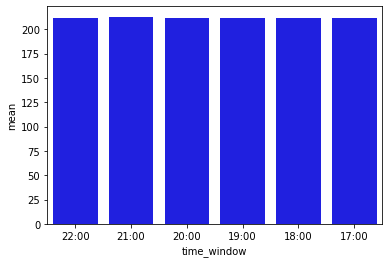

In [77]:
sns.barplot(x='time_window', y='mean', data=df, color='blue')

In [76]:
feature_path = FeaturePath(['Hillshade_9am'])
feature_means = [{'time_window': dataset.name[23:-3], 
                  'mean': get_feature_stats(dataset, feature_path).num_stats.mean}
                             for dataset in stats_list.datasets if dataset.name != 'All Examples']

df = pd.DataFrame(feature_means)

In [101]:
from statistics_utils import get_feature_stats_as_dataframe

feature_path = FeaturePath(['Hillshade_9am'])

get_feature_stats_as_dataframe(stats_list, feature_path)

AttributeError: module 'statistics_utils' has no attribute 'get_feature_stats_as_dataframe'

In [59]:
def retrieve_standard_histogram(feature_stats):
    standard_histogram = [[(bucket.low_value, bucket.high_value, bucket.sample_count) for bucket in histogram.buckets] 
                          for histogram in feature_stats.histograms 
                          if histogram.type == statistics_pb2.Histogram.HistogramType.STANDARD][0]
    
    return standard_histogram

#### Show the distribution of a feature over time

In [61]:
feature_path = FeaturePath(['Aspect'])
histograms = [(dataset.name[23:-3], 
                  retrieve_standard_histogram(get_feature_stats(dataset, feature_path).num_stats))
                             for dataset in stats_list.datasets if dataset.name != 'All Examples']

In [88]:
feature_path = FeaturePath(['Aspect'])
tidy_rows = []
for dataset in stats_list.datasets:
    if dataset.name != 'All Examples':
        for histogram in get_feature_stats(dataset, feature_path).num_stats.histograms:
            if histogram.type == statistics_pb2.Histogram.HistogramType.STANDARD:
                for bucket in histogram.buckets:
                    tidy_rows.append(
                        {'time_window': dataset.name[23:-3],
                         'low_value': bucket.low_value,
                         'high_value': bucket.high_value,
                         'sample_count': bucket.sample_count
                        })
df = pd.DataFrame(tidy_rows)

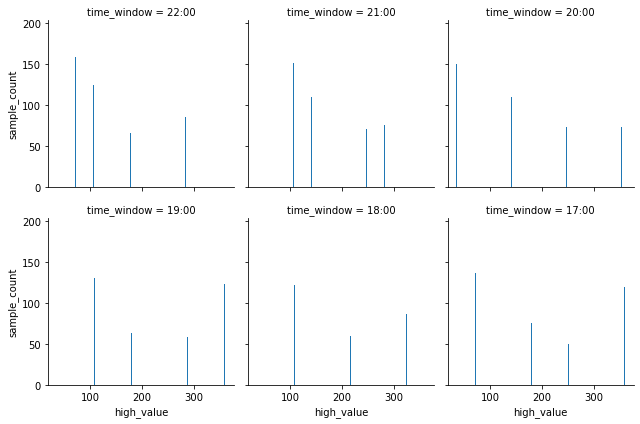

In [96]:
num_of_histograms = len(df['time_window'].unique())
g = sns.FacetGrid(df, col='time_window', col_wrap=3)
g.map(plt.bar, 'high_value', 'sample_count')